<a href="https://colab.research.google.com/github/Evavanrooijen/AfricanGDP/blob/master/Simple_Working_File.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install lmfit

     |████████████████████████████████| 266kB 7.7MB/s 
     |████████████████████████████████| 61kB 10.0MB/s 
     |████████████████████████████████| 235kB 15.3MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.0-cp36-none-any.whl size=87917 sha256=4f4b7fa38a20542517875478b763d49407f30a4e677c36d9f62cbea72aff951b
  Stored in directory: /root/.cache/pip/wheels/1f/93/e9/8d3f759e466f5bbfed3ba1d7dc5b3d4389c469a1ec9a2acaee
  Created wheel for asteval: filename=asteval-0.9.18-cp36-none-any.whl size=17381 sha256=134e21b9557897b9183eaa9d42a55b5985c423cfe11b59ffd1b84d191c273f74
  Stored in directory: /root/.cache/pip/wheels/1c/53/1b/28d929700c9633b1786a4982e6db564ec8326a8930234dcc19
  Created wheel for uncertainties: filename=uncertainties-3.1.2-cp36-none-any.whl size=96457 sha256=25215d07209f300dbe620071249b2e5ef539b81ad7979edc85e015b4c3de1810
  Stored in directory: /root/.cache/pip/wheels/d9/d3/0e/5b0b743a8abd50373705427438456da5dc2621891138d7a618
Successfully built lmfit asteval uncertaintie

In [2]:
import numpy as np
import pandas as pd
from math import sqrt

import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.stats as stats
from scipy.stats import pearsonr
from lmfit import Parameters, minimize, Model # package to apply NLS
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Forecasting real GDP growth for Africa
## Missing Modules
- load African Data

Potential modules


  *   run_simulation.py
* for 100 times per DGP specification: 
* estimate both models
* compare RMSPE
* create table
* export table

  *   model.py
* gather input: JH, CRDW, pos, neg
* estimate model
* rolling forecast
* forecast benchmark

  *   data.py
* simulate(N, T, alp, var)
* load and preprocess: test if right format for model estimation
* Y_growth


### Simulate Data
Create N different time series of length T

In [0]:
# set seed for reproducibility
np.random.seed(1)

In [0]:
def growth_rate(x, steps=1):
  return x[steps:]-x[:-steps]

In [0]:
def create_DGP(N, T, alpha, var_eps):
  # Function that takes all necessary parameters and returns a simulated dataset [NxT]
  Y=np.random.rand(N, T)
  for i in range(N):
    Y[i, 0]=0
    theta = np.random.uniform(1, alpha, 1)
    for t in range(1, T):
      epsilon = np.random.normal(0, sqrt(var_eps), 1)
      Y[i, t]=theta+Y[i, t-1]+epsilon
  Y_growth = np.vstack([growth_rate(row) for row in Y])
  return Y, Y_growth

In [0]:
N = 50
T = 100
alpha = 1
var_eps = 0.5

Y, Y_growth  = create_DGP(N, T, alpha, var_eps)

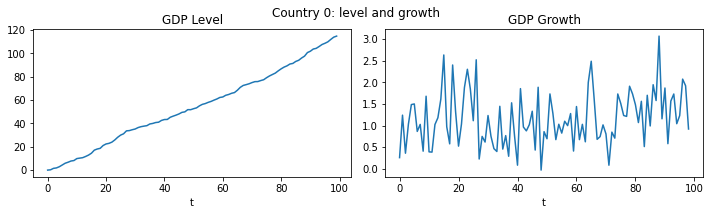

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
fig.suptitle('Country 0: level and growth')
axes[0].plot(Y[0])
axes[0].set_title('GDP Level')
axes[0].set_xlabel('t')
axes[1].plot(Y_growth[0])
axes[1].set_title('GDP Growth')
axes[1].set_xlabel('t')
fig.tight_layout()

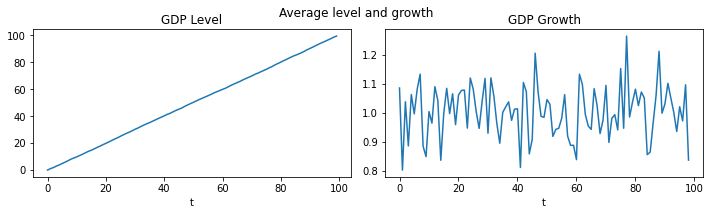

In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
fig.suptitle('Average level and growth')
axes[0].plot(np.mean(Y, axis=0))
axes[0].set_title('GDP Level')
axes[0].set_xlabel('t')
axes[1].plot(np.mean(Y_growth, axis=0))
axes[1].set_title('GDP Growth')
axes[1].set_xlabel('t')
fig.tight_layout()

In [0]:
# unit tests for simulating DGP
assert np.mean(Y, axis = 0)[0] == 0 # start time series 0 at t=0
assert round(np.mean(Y_growth)) == (alpha+1)/2

### Split Sample

Split the sample T into T1 and T2  with T1=aT2, with a=1, 2, 5 or 10 

In [0]:
a = 1

T1_size = int((T*a)/(1+a))  

T1 = Y[:, 0:(T1_size)] # Rounding when casting float to int
T2 = Y[:, (T1_size):T]

In [0]:
np.mean(Y, axis=0)[T1_size:].shape

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
fig.suptitle('Test and train timeline')
axes[0, 0].plot(np.mean(Y, axis=0)[:T1_size])
axes[0, 0].set_title('Average GDP Level: train')
axes[0, 0].set_xlabel('train')
axes[1, 0].plot(np.mean(Y_growth, axis=0)[:T1_size])
axes[1, 0].set_title('Average GDP Growth: test')
axes[1, 0].set_xlabel('train')
axes[0, 1].plot(np.mean(Y, axis=0)[T1_size:])
axes[0, 1].set_title('Average GDP Level: test')
axes[0, 1].set_xlabel('test')
axes[1, 1].plot(np.mean(Y_growth, axis=0)[:T1_size])
axes[1, 1].set_title('Average GDP Growth: test')
axes[1, 1].set_xlabel('test')

fig.tight_layout()

In [0]:
# unit tests
mean_train_growth = round(np.mean(np.mean(Y_growth, axis=0)[:T1_size]))
mean_test_growth = round(np.mean(np.mean(Y_growth, axis=0)[T1_size:]))
assert mean_test_growth == mean_train_growth

## Model Building 


### v Step 1: CRDW Test
y(i, t)= theta(i) + y(j, t) + w(j, t)
for j=1,..., I and j unequal to i. 

Compute residuals w(j, t) and create Cointegration Regression Durbin Watson (CRDW) test statistic as CRDW(j)=2(1-roh(j)) where roh is estimated first order autocorrelation of estimated residuals w(j).

Save regressor y(j, t) where CRDW(j)> tao for next round

In [0]:
def CRDW(i, tao=0.4):
  """This function tests for cointegration
      Args:
        i (int): index of the country we are modeling
        tao (float): critical value (default = 0.4)

      Returns:
        JH (array): An array with the regressors (incl. self)

  """

  JH=Y[i][1:]
  for j in range(N):
      if j!=i:
        y = Y[i]
        x = Y[j]
        x = sm.add_constant(x)

        model = sm.OLS(y, x)
        results = model.fit()
        CRDW_j = stats.stattools.durbin_watson(results.resid)
        if CRDW_j > tao:
          JH = np.vstack((JH, Y[j][1:]))
  assert JH.shape[0]>0 # test if JH contains atleast self
  return JH

### x Step 2: Estimate Cointegration

create matrices with groeivoet, level
calculate S00 S11 S01 S10
calculate eigenvalues
first eigenvalue-> eigenvector is beta for cointegration relation

In [0]:
def cointegration(JH_i):
    """Johansen estimation for cointegration between two time series
    Args:
        JH_i (array): output of CRDW test

    Returns:
        beta (array): eigenvector

    """
    S11 = np.cov(JH_i)
    S01 = np.cov(np.vstack([growth_rate(JH_i[0]), JH_i[1][1:]]))
    S10 = np.cov(np.vstack([JH_i[0][1:], growth_rate(JH_i[1])]))
    S00 = np.cov(np.vstack([ growth_rate(row) for row in JH_i ]))

    beta = np.linalg.eigh(S11-S10.dot(np.linalg.inv(S00)).dot(S01))[1][:, 0]
    return beta

In [0]:
# beta = cointegration(CRDW(0))

### v Step 3: Rank Correlations



In [0]:
def max_min_correlations(i, kn=4, kp=4):
    """Feature selection based on pairwise correlation
    Args:
        i (int): index of the country we are modeling
        tao (float): critical value (default = 0.4)

    Returns:
        JH (array): An array with the regressors (incl. self)

    """
    corr_i = np.zeros(N)
    for j in range(N):
      corr_i[j] = pearsonr(Y_growth[i], Y_growth[j])[0]
    
    pos = Y_growth[np.argpartition(corr_i, -(kp+1))[-(kp+1):-1]]
    #pos = Y_growth[corr_i.argsort()[(kp+1):-1]]
    assert pos.shape == (kp, T-1)
    neg = Y_growth[corr_i.argsort()[:kn]]
    assert neg.shape == (kn, T-1)
    #neg = Y_growth[np.argpartition(correlation(7), -5)[-5:-1]]
    return pos, neg

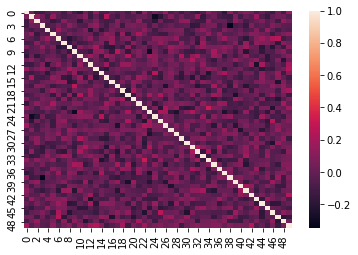

In [13]:
N = 50
corr = np.ones([N, N])
for i in range(N):
  for j in range(N):
    corr[i, j] = pearsonr(Y_growth[i], Y_growth[j])[0]

import seaborn as sns
sns.heatmap(corr)

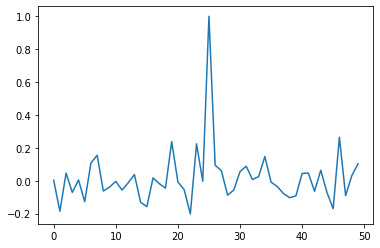

In [14]:
plt.plot(corr[25])

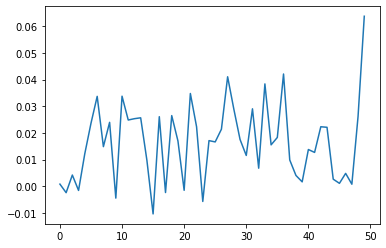

In [15]:
plt.plot(np.mean(corr, axis=0))

In [16]:
np.mean(np.mean(corr, axis=0))

0.01643748191390179

In [0]:
alpha = 5
var_eps = 1
N = 50
def test_corr(N, alpha, var_eps):
  X, X_growth = create_DGP(N, 100, alpha, var_eps)

  corr_X = np.ones([N, N])
  for i in range(N):
    for j in range(N):
      corr_X[i, j] = pearsonr(X_growth[i], X_growth[j])[0]
  return np.mean(corr_X)

In [18]:
for alpha in [1, 2, 3, 4, 5]:
  print(str(alpha) + ' alpha returns correlation : '+str(test_corr(50, alpha, 0.5)))
  
  print(str(alpha) + ' alpha returns correlation : '+str(test_corr(50, alpha, 1)))
for var_eps in [0.5, 0.7, 0.9, 1]:
  print(str(var_eps) + ' var_eps returns correlation : '+str(test_corr(50, 1, var_eps)))
  
  print(str(var_eps) + ' var_eps returns correlation : '+str(test_corr(50, 2, var_eps)))
  
  print(str(var_eps) + ' var_eps returns correlation : '+str(test_corr(50, 5, var_eps)))

1 alpha returns correlation : 0.017840829989224993
1 alpha returns correlation : 0.021298850086356767
2 alpha returns correlation : 0.019913846230078504
2 alpha returns correlation : 0.019025911783503227
3 alpha returns correlation : 0.021348503098557993
3 alpha returns correlation : 0.022461225725882078
4 alpha returns correlation : 0.017278265925514517
4 alpha returns correlation : 0.016428440797564114
5 alpha returns correlation : 0.018371591952497438
5 alpha returns correlation : 0.019633204961581777
0.5 var_eps returns correlation : 0.021191173006445106
0.5 var_eps returns correlation : 0.02213596762349401
0.5 var_eps returns correlation : 0.01995061756173222
0.7 var_eps returns correlation : 0.016714421089840285
0.7 var_eps returns correlation : 0.02090083031344547
0.7 var_eps returns correlation : 0.019824439855905915
0.9 var_eps returns correlation : 0.023210282643362497
0.9 var_eps returns correlation : 0.01945913603363921
0.9 var_eps returns correlation : 0.01950342115159354


 Where does this correlation come from?

expected variance of growth rate is (alpha-1)**2/12  from theta and 1 from epsilon

Somehow for different var_eps and alpha always around 0.02

In [0]:
# ??
np.mean(corr_X)

### v Step 4: Define Model
For every country (row), we retrieve an array of correlated countries (rows) and an array of countries in the (potential) cointegration relation.

Steps involved:

  * Define function(independent, parameters)
*   parameter: mu, gamma, beta, alphas
*  independent vars: pos, neg, JH
*  rank = JH.shape[0]-1
*  returns fitted value: f(pos, neg, JH) = growth[y]

  *   Estimate parameters
* desired output = growth[y]
* input = pos[y], neg[y], CRDW[y]
* params: mu, gamma, beta, ...
* fit by NLS: minimize des_out - fit(params, indep)

  * Forecast
* Train to retrieve params per i, training set
* Predict one step ahead
* store RMSPE



In [0]:
N, T = Y.shape
i = 3

In [20]:
JH = CRDW(i)
pos, neg = max_min_correlations(i)

params = Parameters()
rank = JH.shape[0]
for r in range(1, rank):
  params.add('beta'+str(r), value = np.random.normal(-1, 1), max=0)

params.add('mu', value = np.random.normal(0, 1))
params.add('alpha_self', value = np.random.normal(0, 1))
params.add('alpha_pos', value = np.random.normal(0, 1))
params.add('alpha_neg', value = np.random.normal(0, 1))
params.add('theta_pos', value = np.random.normal(0, 1))
params.add('theta_neg', value = np.random.normal(0, 1))
params.add('gamma', value = np.random.normal(0, 1))

params.pretty_print()

Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
alpha_neg    -0.5207     -inf      inf     None     True     None     None
alpha_pos    -0.1866     -inf      inf     None     True     None     None
alpha_self      1.36     -inf      inf     None     True     None     None
beta1         -2.097     -inf        0     None     True     None     None
beta2         -2.425     -inf        0     None     True     None     None
gamma          0.954     -inf      inf     None     True     None     None
mu           -0.3598     -inf      inf     None     True     None     None
theta_neg    -0.1099     -inf      inf     None     True     None     None
theta_pos    -0.4207     -inf      inf     None     True     None     None


In [0]:
def residual(params, pos, neg, JH):
  rank = JH.shape[0] # test if this works when rank = 1 NOPE

  mu = params['mu']
  alpha_self = params['alpha_self']
  alpha_pos = params['alpha_pos']
  alpha_neg = params['alpha_neg']
  theta_pos = params['theta_pos']
  theta_neg = params['theta_neg']
  gamma = params['gamma']

  beta = np.ones(rank)
  for r in range(1, rank):
    beta[r] = params['beta'+str(r)]

  assert beta[0] == 1
  #assert np.sum(beta>0) == 1
  assert beta.size == rank
      
  alpha_i_j_p = np.array([alpha_pos, alpha_pos*theta_pos, alpha_pos*(theta_pos**2), alpha_pos*(theta_pos**3)])
  alpha_i_j_n = np.array([alpha_neg, alpha_neg*theta_neg, alpha_neg*(theta_neg**2), alpha_neg*(theta_neg**3)])
  
  assert alpha_i_j_p.size == 4
  assert alpha_i_j_n.size == 4

  # TO-DO growth rate t-1, alpha_self ??
  # correlation = alpha_self * growth_rate(Y) + alpha_i_j_n.dot(neg) + alpha_i_j_p.dot(pos)
  correlation = alpha_i_j_n.dot(neg) + alpha_i_j_p.dot(pos)

  cointegration = gamma * (beta.dot(JH))

  model = cointegration + correlation + mu

  return growth_rate(Y[3]) - model

In [0]:
def function(pos, neg, JH, mu, alpha_self, alpha_pos, alpha_neg, theta_pos, theta_neg, gamma, beta):
  rank = JH.shape[0] # test if this works when rank = 1 NOPE

  assert beta[0] == 1
  #assert np.sum(beta>0) == 1
  assert beta.size == rank
      
  alpha_i_j_p = np.array([alpha_pos, alpha_pos*theta_pos, alpha_pos*(theta_pos**2), alpha_pos*(theta_pos**3)])
  alpha_i_j_n = np.array([alpha_neg, alpha_neg*theta_neg, alpha_neg*(theta_neg**2), alpha_neg*(theta_neg**3)])
  
  assert alpha_i_j_p.size == 4
  assert alpha_i_j_n.size == 4

  # TO-DO growth rate t-1, alpha_self ??
  # correlation = alpha_self * growth_rate(Y) + alpha_i_j_n.dot(neg) + alpha_i_j_p.dot(pos)
  correlation = alpha_i_j_n.dot(neg) + alpha_i_j_p.dot(pos)

  cointegration = gamma * (beta.dot(JH))

  model = cointegration + correlation + mu

  return model

In [0]:
def function(pos, neg, JH, gamma, beta, mu):
  rank = JH.shape[0] # test if this works when rank = 1 NOPE

  beta = np.ones(rank)
  for r in range(1, rank):
    beta[r] = params['beta'+str(r)]

  assert beta[0] == 1
  assert np.sum(beta>0) == 1
  assert beta.size == rank
      
  alpha_i_j_p = np.ones(4)
  alpha_i_j_n = np.ones(4)
  
  assert alpha_i_j_p.size == 4
  assert alpha_i_j_n.size == 4

  # TO-DO growth rate t-1, alpha_self ??
  # correlation = alpha_self * growth_rate(Y) + alpha_i_j_n.dot(neg) + alpha_i_j_p.dot(pos)
  correlation = alpha_i_j_n.dot(neg) + alpha_i_j_p.dot(pos)

  cointegration = gamma * (beta.dot(JH))

  return cointegration + correlation + mu


### Step 5: Estimate Parameters (NLS)

NLS predict growth y_i on constant_i lagged growth correlated others and cointegration combinations

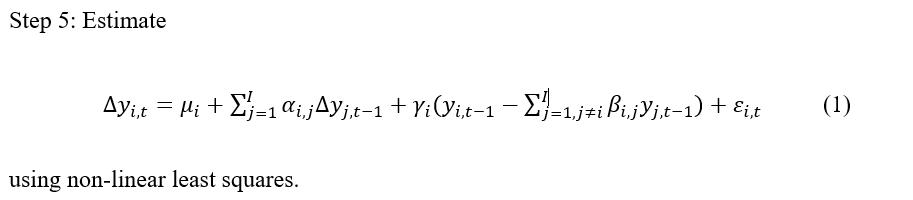

In [24]:
import time
start = time.time()
out = minimize(residual, params, args=(pos, neg, JH), method='leastsq', maxfev=1000000)
print(out.message)
print('Estimation took: {} seconds'.format(time.time() - start))

Fit succeeded. Could not estimate error-bars.
Estimation took: 12.408050298690796 seconds


**TO-DO**
- add other paramters for alpha

In [0]:
mu_hat = out.params['mu'].value
gamma_hat = out.params['gamma'].value
output = function(pos, neg, JH, mu_hat, [1, -0.4, -0.2], 0.9)

beta = np.ones(rank)
for r in range(1, rank):
  beta[r] = out.params['beta'+str(r)].value

assert beta.size == rank
assert beta[0] == 1
assert np.sum(beta > 0) == 1



In [26]:
pred = function(pos, neg, JH, mu_hat, beta, gamma_hat)
pred.shape

(99,)

In [27]:
truth = Y_growth[i]
RMSPE = (pred - truth) #still have to divide by truth! 
np.mean(RMSPE)

7.1013256440066925

### v Step 6: Benchmark (IMA(1, 1))
https://towardsdatascience.com/arima-forecasting-in-python-90d36c2246d3

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   99
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -151.995
Method:                       css-mle   S.D. of innovations              1.122
Date:                Thu, 02 Apr 2020   AIC                            307.990
Time:                        14:06:11   BIC                            313.181
Sample:                             1   HQIC                           310.090
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.D.y      0.4514      0.077      5.846      0.000       0.300       0.603
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -2.2156           +0.0000j            2.2156            0.5000
-----------------------------------------------------------------------------
"""

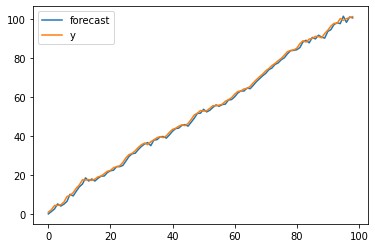

In [0]:
IMA_model = ARIMA(Y[i], order=(0, 1, 1))
results = IMA_model.fit(trend='nc') # should have trend I think?
IMA_resid = results.resid
results.plot_predict()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   98
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -121.142
Method:                       css-mle   S.D. of innovations              0.814
Date:                Thu, 02 Apr 2020   AIC                            246.284
Time:                        14:06:00   BIC                            251.454
Sample:                             1   HQIC                           248.375
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.D.y     -1.0000      0.031    -32.673      0.000      -1.060      -0.940
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

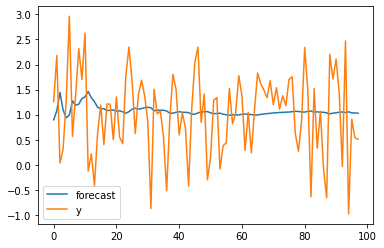

In [0]:
IMA_model = ARIMA(Y_growth[i], order=(0, 1, 1))
results = IMA_model.fit(trend='nc') # should have trend I think?
IMA_resid = results.resid
results.plot_predict()
results.summary()


In [0]:
from sklearn.metrics import mean_squared_error
def baseline(i):
  "function to estimate IMA using rolling window, returns MSPE"  
  train, test = T1[i], T2[i]
  history = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
  # MSE = mean_squared_error(test, predictions)
  return predictions

In [0]:
def recursive_estimation(T1_size, T2=30, steps_ahead=1):
  i = 0
  for j in range(T2):
    train_data = Y[i][:(T1_size+j)]
    IMA_model = ARIMA(train_data, order=(0, 1, 1))
    results = IMA_model.fit(trend='nc')

    fc = IMA_model.predict(Y[i][T1+j+1])
    forecasts.append(fc)
    
    RMSPE = np.sqrt(np.mean(np.square(((Y[i][T-T2:] - forecasts) / Y[i][T-T2])), axis=0))
  return RMSPE

In [0]:
i = 0
T1=20
T2=30
steps_ahead=1
for j in range(T2):
  train_data = Y[i][:(T1+j)]
  IMA_model = ARIMA(train_data, order=(0, 1, 1))
  results = IMA_model.fit(trend='nc')

  fc = IMA_model.predict(Y[i][T1+j+1])
  forecasts.append(fc)
    
RMSPE = np.sqrt(np.mean(np.square(((Y[i][T-T2:] - forecasts) / Y[i][T-T2])), axis=0))


## Construct forecasts

Create recursively T2 1-step ahead forecasts for each country (i).

Compute Root Mean Squared Prediction Error

Count #times RMSPE (us) < RMSPE(IMA)




In [0]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
fig.suptitle('Residuals for i = 2, model comparison')
axes[0].plot(out.residual)
axes[0].set_title('Us')
axes[0].set_xlabel('t')
axes[1].plot(IMA_resid)
axes[1].set_title('IMA(1, 1)')
axes[1].set_xlabel('t')
fig.tight_layout()

In [0]:
IMA_model = ARIMA(Y[0], order=(0, 1, 1))
results = IMA_model.fit(trend='nc')

results.plot_predict()
results.summary()

In [0]:
def recursive_estimation(model, T1, T2, steps_ahead=1):
  for j in range(T2):
    train_data = Y[i][:(T1+j)]
    model_IMA = ARIMA(train_data, order=(0, 1, 1))
    results = IMA_model.fit(trend='nc')

    fc = IMA_model.predict(Y[i][T1+j+1])
    forecasts.append(fc)
    
    RMSPE = np.sqrt(np.mean(np.square(((Y[i][T-T2:] - forecasts) / Y[i][T-T2])), axis=0))
  return RMSPE

In [0]:
# test
RMSPE_us=[1, 1, 1, 1, 1, 1]
RMSPE_IMA=[2, 2, 2, 2, 2, 2]


In [0]:
def compare_models(RMSPE_IMA, RMSPE_us):
  for j in range(6):
    if (RMSPE_us[j]<RMSPE_IMA[i]):
      beaten+=1
  return beaten

# Main Script

In [0]:
[N, T] = Y.shape
for i in range(N):
  estimate_model(i)
  #RMSPE_IMA = estimate_model(i)


In [0]:
i = 7
JH = CRDW(i)
pos, neg = correlation(i)
beta = cointegration(JH)
country = Y_growth[i]
 # TO-DO: growth rates!

def residual(params, pos, neg, country, JH):
  mu = params['mu']
  alpha_self = params['alpha_self']
  alpha_pos = params['alpha_pos']
  alpha_neg = params['alpha_neg']
  theta_pos = params['theta_pos']
  theta_neg = params['theta_neg']
  gamma = params['gamma']
  #beta = params['beta']

  alpha_i_j_p = np.array([alpha_pos, alpha_pos*theta_pos, alpha_pos*(theta_pos**2), alpha_pos*(theta_pos**3)])
  alpha_i_j_n = np.array([alpha_neg, alpha_neg*theta_neg, alpha_neg*(theta_neg**2), alpha_neg*(theta_neg**3)])
  
  correlation = alpha_self * (country) + alpha_i_j_n.dot(neg) + alpha_i_j_p.dot(pos)
  
  cointegration = gamma*(country - beta.dot(JH[:, :-1])) # check if deleted right time var

  model = cointegration + correlation + mu
  return Y_growth[0]-model

params = Parameters()
params.add('mu', value = 1)
params.add('alpha_self', value = 2)
params.add('alpha_pos', value = 2)
params.add('alpha_neg', value = 2)
params.add('theta_pos', value = 2)
params.add('theta_neg', value = 2)
params.add('gamma', value = 5)
#params.add('beta', value=beta.all()) # number depends on resuls CRDW

minimiz = minimize(residual, params, args=(pos, neg, country, JH), method='leastsq')

In [0]:
minimiz.params.pretty_print()

In [0]:
def model(i, mu, alpha_self, alpha_pos, alpha_neg, theta_pos, theta_neg, gamma):
  JH = CRDW(i)
 # pos, neg = correlation(i)
  #beta = cointegration(JH)
  S11 = np.cov(JH_i)
  S01 = np.cov(np.vstack([growth_rate(JH_i[0]), JH_i[1][1:]]))
  S10 = np.cov(np.vstack([JH_i[0][1:], growth_rate(JH_i[1])]))
  S00 = np.cov(np.vstack([ growth_rate(row) for row in JH_i ]))

  beta = np.linalg.eigh(S11-S10.dot(np.linalg.inv(S00)).dot(S01))[1][:, 0]
  country = Y_growth[i]
  corr_i = np.zeros(N)
  for j in range(N):
    corr_i[j] = pearsonr(Y_growth[i], Y_growth[j])[0] # drop argmax for i=j (1)
        # absolute value, take highest 8
  
  pos = Y_growth[np.argpartition(corr_i, -5)[-5:-1]]
  assert pos.shape[0] == 4
  neg = Y_growth[corr_i.argsort()[:4]]
  assert neg.shape[0] == 4


  alpha_i_j_p = np.array([alpha_pos, alpha_pos*theta_pos, alpha_pos*(theta_pos**2), alpha_pos*(theta_pos**3)])
  alpha_i_j_n = np.array([alpha_neg, alpha_neg*theta_neg, alpha_neg*(theta_neg**2), alpha_neg*(theta_neg**3)])
  
  correlation = alpha_self * (country) + alpha_i_j_n.dot(neg) + alpha_i_j_p.dot(pos)
  beta = cointegration(JH)
  cointegration = gamma*(country - beta.dot(CRDW(i)[:, :-1])) # check if deleted right time var

  out = cointegration + correlation + mu
  return out


In [0]:
popt, pcov = curve_fit(model, 7, Y_growth[7])

In [0]:
pars = model.make_params(a=3, b=0.5)
mod = Model(myfunc)
mod.set_param_hint('a', value=1.0)
mod.set_param_hint('b', value=0.3, min=0, max=1.0)
pars = mod.make_params()

#mod.eval or mod.fit ? might be useful here

In [0]:
range_N=[50]
range_T=[50]
range_alpha=[2, 5, 10]
range_a=[1, 2, 5, 10]
range_var_eps=[0.5, 1]

results = { 'DGP': [], 'mean rank': []}

for var_eps in range_var_eps:
  for a in range_a:
    for alpha in range_alpha:
      for T in range_T:
        for N in range_N:
          #results['DGP'].append( 'N = '+ str(N) + ' T = '+ str(T)+' alpha = '+ str(alpha)+' a = '+ str(a)+' var_eps = '+ str(var_eps))
          rank_per_run = []
          for s in range(5):
            cointegration = 0
            number_runs = number_runs+1
            Y = create_DGP(N, T, alpha, a, var_eps)
            for i in range(N):
              r = 0
              if np.array_equal(CRDW(i, tao=0.4), Y[i]) == False:
                r = CRDW(i).shape[0]-1
                cointegration = cointegration + r
            rank_per_run.append(cointegration/N)
          results['DGP'].append( 'N = '+ str(N) + ' T = '+ str(T)+' alpha = '+ str(alpha)+' a = '+ str(a)+' var_eps = '+ str(var_eps))
          results['mean rank'].append(np.mean(rank_per_run))
          print(rank_per_run)

results = pd.DataFrame(results)

In [0]:
def run_simulation(N, T, alpha, a, var_eps, tao):
  Y = create_DGP(N, T, alpha, a, var_eps)

  for i in range(N):
    # Build single equation model
    JH = CRDW(i)
    # estimate cointegration relation (lin comb)
    pairwise_correlation(i)


    # Build IMA(1, 1) model
    model_IMA = ..


    RMSPE_us = recursive_estimation(model_us, T1, T2, steps_ahead=1)
    RMSPE_IMA = recursive_estimation(model_IMA, T1, T2, steps_ahead=1)

  return compare_models(RMSPE_IMA, RMSPE_us)

# Export Results

In [0]:
simulation_runs=1
N=100
T=100
alpha=1
a=1
var_eps=0.5
tao=0.4

results = pd.DataFrame()
for i in range(simulation_runs):
  results.append(run_simulation(N, T, alpha, a, var_eps, tao))
  
results.to_csv('EIRAP-results.csv')